In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


## Recommander des véhicules selon la popularité dans une région spécifique :

- Question : "Quels types de véhicules sont les plus vendus dans une région donnée ?"
Avec les informations sur l'état (région) et le vendeur, vous pouvez recommander des véhicules populaires dans des régions spécifiques ou auprès de certains types de vendeurs.

In [50]:
file_path='car_prices.csv'
df_raw = pd.read_csv(file_path)

In [51]:
df_raw.head()

year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1                 kia motors america  inc  20800.0       21500.0   
2  financial services remarketing (lease)  31900.0       30000.0   
3                 volvo na rep/world omni  27500.0       27750.0   
4  financial services remarketing (lease)  66000.0       67000.0   

                                  saledate  
0  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
1  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
2  Thu Jan 15 2015 04:30:00 GMT-0800 (PST)  
3  Thu Jan 29 2015 04:30:00 GMT-0800 (PST)  
4  Thu Dec 18 2014 12:30:00 GMT-0800 (PST)

In [52]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


Pour répondre à la question "Quels types de véhicules sont les plus vendus dans une région donnée ?", certaines colonnes du dataset sont plus pertinentes que d'autres. Voici un aperçu des colonnes qui sont **pertinentes** et celles qui sont **moins pertinentes** pour cette question :

### **Colonnes pertinentes :**
1. **year** : L'année du véhicule peut aider à identifier les tendances de vente selon l'âge des véhicules.
2. **make** : Le constructeur est essentiel pour déterminer quels types de véhicules sont populaires dans une région.
3. **model** : Le modèle du véhicule permet de préciser encore plus les types de véhicules vendus.
4. **trim** : Le niveau de finition (trim) peut aussi influencer la popularité d'un véhicule.
5. **body** : Le type de carrosserie peut aider à identifier si certains styles (SUV, berline, etc.) sont plus populaires.
6. **transmission** : Le type de transmission (manuelle ou automatique) peut aussi influencer les ventes, surtout selon les régions.
7. **state** : Cette colonne est essentielle puisqu'elle représente la région dans laquelle le véhicule a été vendu.
8. **condition** : L'état du véhicule peut avoir un impact sur sa popularité dans une région spécifique.
9. **odometer** : Le kilométrage peut être un facteur déterminant pour les ventes de véhicules dans une région spécifique.
10. **sellingprice** : Le prix de vente est un critère clé pour comprendre quels véhicules sont populaires et accessibles dans une région donnée.
11. **saledate** : Cette colonne peut être utilisée pour observer les tendances saisonnières ou annuelles dans les ventes de véhicules.

### **Colonnes moins pertinentes :**
1. **vin** : Le numéro d'identification du véhicule est unique pour chaque voiture, donc il n'apporte pas d'informations utiles pour déterminer les tendances générales de vente.
2. **color** : Bien que la couleur puisse influencer les préférences individuelles, elle n'est probablement pas un facteur clé pour répondre à cette question.
3. **interior** : De même que pour la couleur extérieure, l'intérieur d'un véhicule est un détail moins pertinent dans le contexte de popularité régionale.
4. **seller** : Le vendeur peut être moins pertinent si l'on se concentre sur la popularité des véhicules selon la région, plutôt que selon qui vend les véhicules.
5. **mmr** : Les valeurs du Manheim Market Report représentent une estimation de la valeur marchande du véhicule, mais elles ne sont pas directement liées à la popularité des types de véhicules vendus.

En résumé, les colonnes **vin**, **color**, **interior**, **seller**, et dans une certaine mesure **mmr** peuvent être considérées comme moins pertinentes pour cette analyse. Tu peux les ignorer ou les retirer du prétraitement pour te concentrer sur les autres colonnes plus pertinentes.

In [53]:
# Liste des colonnes à supprimer
columns_to_drop = ['vin', 'color', 'interior', 'seller', 'mmr']

# Suppression des colonnes non pertinentes
df = df_raw.drop(columns=columns_to_drop)

# Afficher les premières lignes du DataFrame après suppression
print(df.head())


   year   make                model        trim   body transmission state  \
0  2015    Kia              Sorento          LX    SUV    automatic    ca   
1  2015    Kia              Sorento          LX    SUV    automatic    ca   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic    ca   
3  2015  Volvo                  S60          T5  Sedan    automatic    ca   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic    ca   

   condition  odometer  sellingprice                                 saledate  
0        5.0   16639.0       21500.0  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
1        5.0    9393.0       21500.0  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
2       45.0    1331.0       30000.0  Thu Jan 15 2015 04:30:00 GMT-0800 (PST)  
3       41.0   14282.0       27750.0  Thu Jan 29 2015 04:30:00 GMT-0800 (PST)  
4       43.0    2641.0       67000.0  Thu Dec 18 2014 12:30:00 GMT-0800 (PST)  


In [54]:
#suppression des lines incompletes (contenant des valeurs manquantes)
df.dropna(inplace=True)
df.shape

(472869, 11)

In [55]:

# Liste des colonnes catégorielles et numériques
categorical_cols = ['make', 'model', 'trim', 'body', 'transmission', 'state']
numerical_cols = ['odometer', 'condition', 'sellingprice']

# Création de l'encodeur pour les variables catégorielles
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Création du scaler pour les variables numériques
numerical_transformer = RobustScaler()

# Création d'un ColumnTransformer pour appliquer les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)

# Application des transformations avec un Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Application du pipeline sur les données (fit_transform)
processed_data = pipeline.fit_transform(df)

# Récupération des noms des colonnes encodées
encoded_cat_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_columns = list(encoded_cat_cols) + numerical_cols

# Conversion des données transformées en DataFrame
processed_df = pd.DataFrame(processed_data, columns=all_columns)

# Vérifier le DataFrame transformé
print(processed_df.head())


   make_Aston Martin  make_Audi  make_BMW  make_Bentley  make_Buick  \
0                0.0        0.0       0.0           0.0         0.0   
1                0.0        0.0       0.0           0.0         0.0   
2                0.0        0.0       1.0           0.0         0.0   
3                0.0        0.0       0.0           0.0         0.0   
4                0.0        0.0       1.0           0.0         0.0   

   make_Cadillac  make_Chevrolet  make_Chrysler  make_Daewoo  make_Dodge  ...  \
0            0.0             0.0            0.0          0.0         0.0  ...   
1            0.0             0.0            0.0          0.0         0.0  ...   
2            0.0             0.0            0.0          0.0         0.0  ...   
3            0.0             0.0            0.0          0.0         0.0  ...   
4            0.0             0.0            0.0          0.0         0.0  ...   

   state_sc  state_tn  state_tx  state_ut  state_va  state_wa  state_wi  \
0       0.0

In [56]:


# Construire une colonne unique pour représenter les véhicules par make et model
df['vehicle'] = df['make'] + ' ' + df['model']

# Créer la matrice région-véhicule (pivot table)
region_vehicle_matrix = df.pivot_table(index='state', columns='vehicle', values='sellingprice', aggfunc='count', fill_value=0)

# Vérifier la forme de la matrice
print(region_vehicle_matrix.shape)

# Convertir en matrice sparse (pour efficacité)
region_vehicle_sparse = csr_matrix(region_vehicle_matrix)


(34, 776)


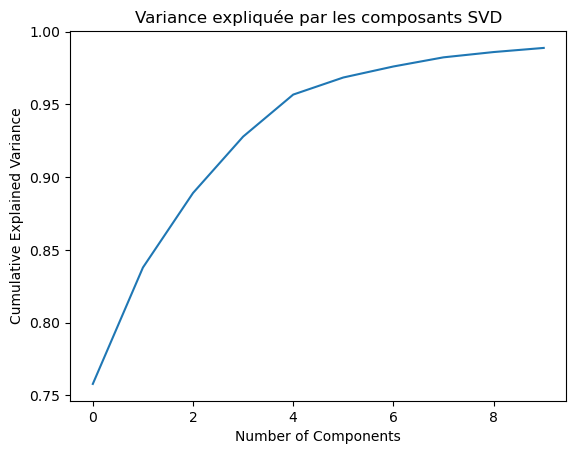

In [57]:
# Utilisation de la décomposition SVD pour factoriser la matrice
svd = TruncatedSVD(n_components=10)  # Choisir un nombre de composants
region_vehicle_svd = svd.fit_transform(region_vehicle_sparse)

# Visualiser la variance expliquée par les composants
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance expliquée par les composants SVD')
plt.show()


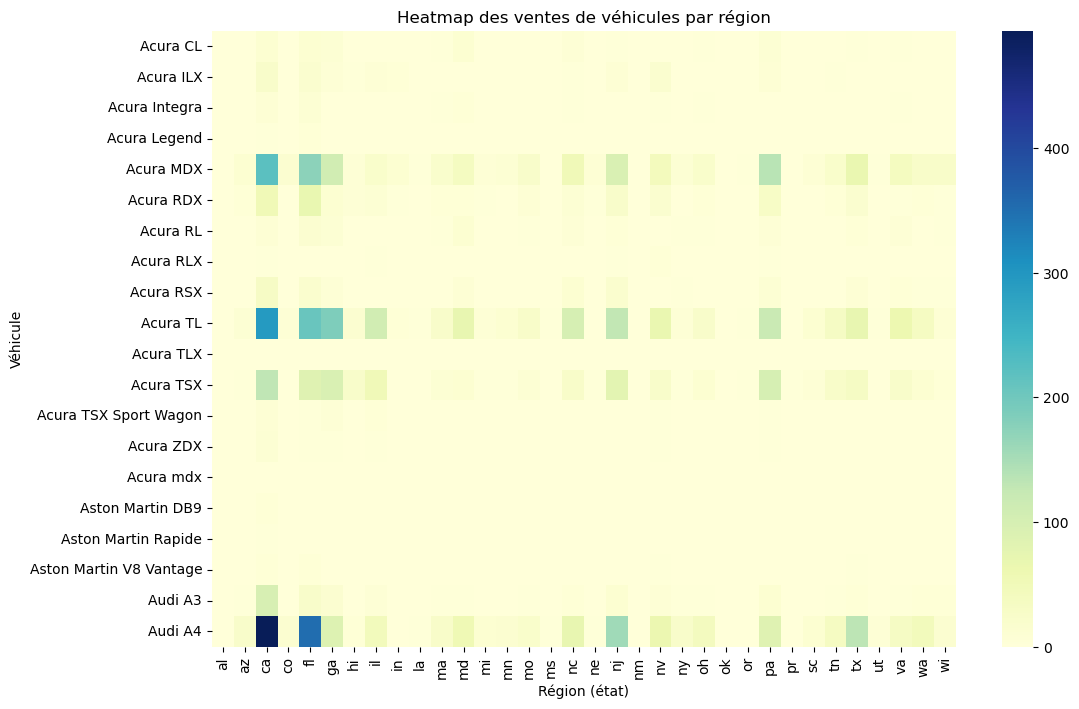

In [58]:
# Heatmap pour visualiser les ventes par région pour les véhicules les plus populaires
plt.figure(figsize=(12, 8))
sns.heatmap(region_vehicle_matrix.T.iloc[:20], cmap='YlGnBu', annot=False)  # Affiche les 20 premiers véhicules
plt.title('Heatmap des ventes de véhicules par région')
plt.xlabel('Région (état)')
plt.ylabel('Véhicule')
plt.show()


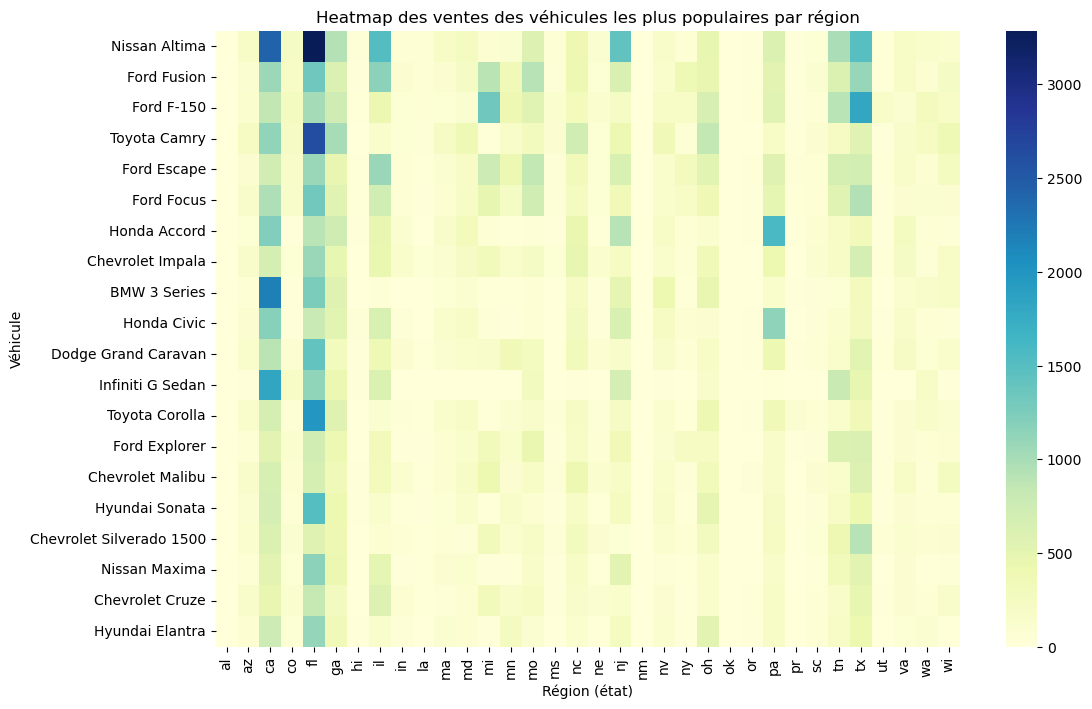

In [59]:
# Calculer le nombre total de ventes pour chaque véhicule (somme des ventes par région)
vehicle_popularity = region_vehicle_matrix.sum(axis=0).sort_values(ascending=False)

# Sélectionner les 20 véhicules les plus vendus
top_vehicles = vehicle_popularity.head(20).index

# Filtrer la matrice pour ces véhicules
top_vehicle_matrix = region_vehicle_matrix[top_vehicles]

# Afficher la heatmap des véhicules les plus populaires par région
plt.figure(figsize=(12, 8))
sns.heatmap(top_vehicle_matrix.T, cmap='YlGnBu', annot=False)
plt.title('Heatmap des ventes des véhicules les plus populaires par région')
plt.xlabel('Région (état)')
plt.ylabel('Véhicule')
plt.show()


In [60]:
# Obtenir les termes les plus importants par région (données factorisées)
def get_top_vehicles(region_index, region_vehicle_matrix, n=15):
    region_data = region_vehicle_matrix.iloc[region_index]
    sorted_vehicles = region_data.sort_values(ascending=False)
    return sorted_vehicles.head(n)

Top véhicules en Californie :
vehicle
Nissan Altima            2425
BMW 3 Series             2183
Infiniti G Sedan         1829
Honda Accord             1221
Honda Civic              1181
Mercedes-Benz C-Class    1181
BMW 5 Series             1163
Toyota Camry             1133
Ford Fusion              1071
Mercedes-Benz E-Class     996
Ford Focus                975
Volkswagen Jetta          918
Dodge Grand Caravan       895
Ford F-150                848
Ford Mustang              838
Name: ca, dtype: int64


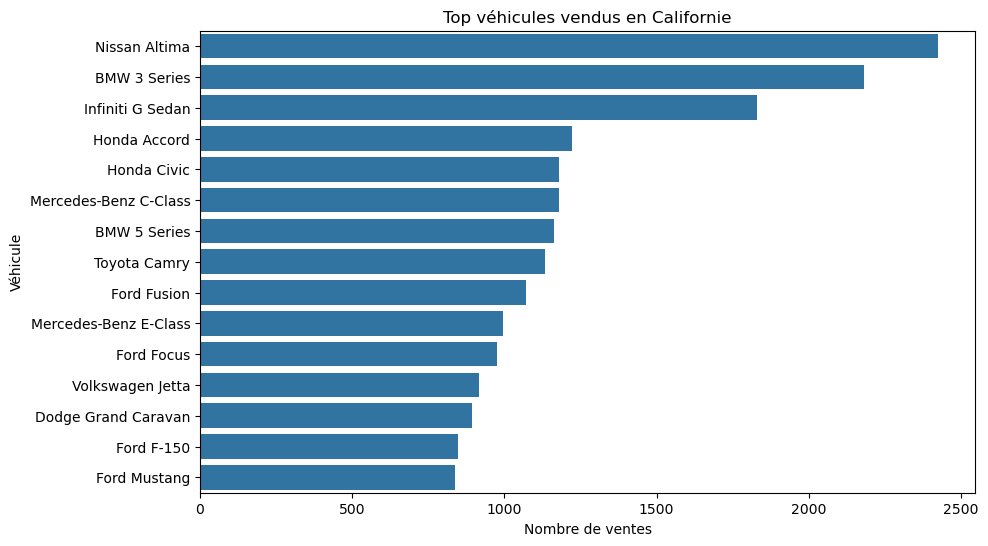

In [61]:


# Exemple : Quels sont les véhicules les plus populaires en Californie ?
california_index= region_vehicle_matrix.index.get_loc('ca')  # Index de la floride dans la matrice
top_vehicles_california = get_top_vehicles(california_index, region_vehicle_matrix)

# Afficher les résultats
print("Top véhicules en Californie :")
print(top_vehicles_california)

# Visualiser avec un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_vehicles_california.values, y=top_vehicles_california.index)
plt.title('Top véhicules vendus en Californie')
plt.xlabel('Nombre de ventes')
plt.ylabel('Véhicule')
plt.show()


Top véhicules en Floride :
vehicle
Nissan Altima                3286
Toyota Camry                 2620
Toyota Corolla               1977
Hyundai Sonata               1502
Dodge Grand Caravan          1423
Ford Fusion                  1344
Ford Focus                   1312
BMW 3 Series                 1248
Nissan Maxima                1165
Infiniti G Sedan             1140
Hyundai Elantra              1105
Chevrolet Impala             1089
Ford Escape                  1082
Ford F-150                   1023
Chrysler Town and Country     955
Name: fl, dtype: int64


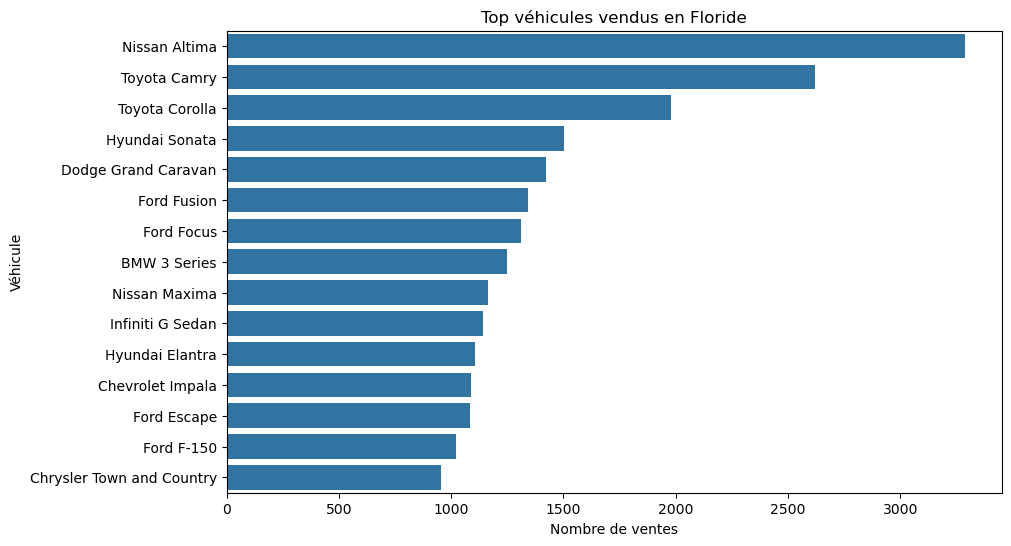

In [62]:
# Exemple : Quels sont les véhicules les plus populaires en Floride ?
florida_index = region_vehicle_matrix.index.get_loc('fl')  
top_vehicles_florida = get_top_vehicles(florida_index, region_vehicle_matrix)

# Afficher les résultats
print("Top véhicules en Floride :")
print(top_vehicles_florida)

# Visualiser avec un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_vehicles_florida.values, y=top_vehicles_florida.index)
plt.title('Top véhicules vendus en Floride')
plt.xlabel('Nombre de ventes')
plt.ylabel('Véhicule')
plt.show()


# Recommander des véhicules selon le budget d'un acheteur :

- Question : "Quels véhicules recommander en fonction du budget d'un acheteur potentiel ?"


In [63]:
print(df['vehicle'].value_counts())


vehicle
Nissan Altima              16359
Ford Fusion                12155
Ford F-150                 11968
Toyota Camry               10989
Ford Escape                10679
                           ...  
Suzuki Sidekick                1
BMW 8 Series                   1
Mercedes-Benz 420-Class        1
Oldsmobile Achieva             1
Ferrari 458 Italia             1
Name: count, Length: 776, dtype: int64


C:\Users\amira\AppData\Local\Temp\ipykernel_10528\2436035938.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Marque', bbox_to_anchor=(1.05, 1), loc='upper left')


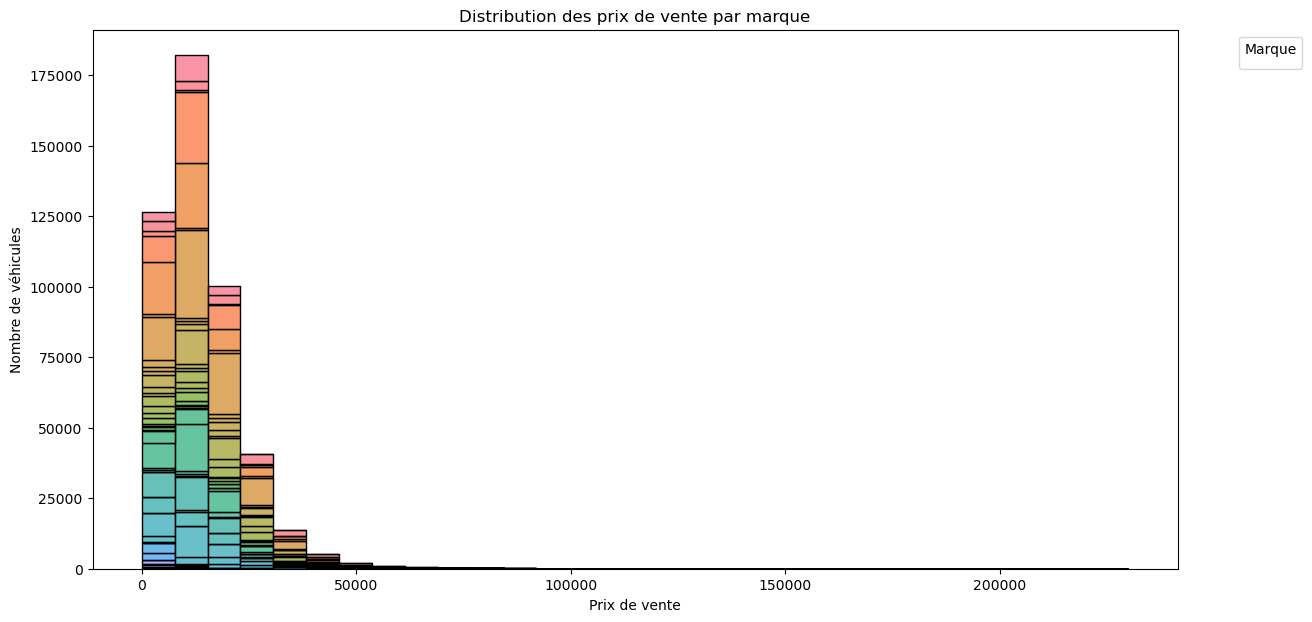

In [64]:

# Histogramme de la distribution des prix de vente par marque
plt.figure(figsize=(14, 7))
sns.histplot(data=df, x='sellingprice', hue='make', multiple='stack', bins=30)
plt.title('Distribution des prix de vente par marque')
plt.xlabel('Prix de vente')
plt.ylabel('Nombre de véhicules')
plt.legend(title='Marque', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


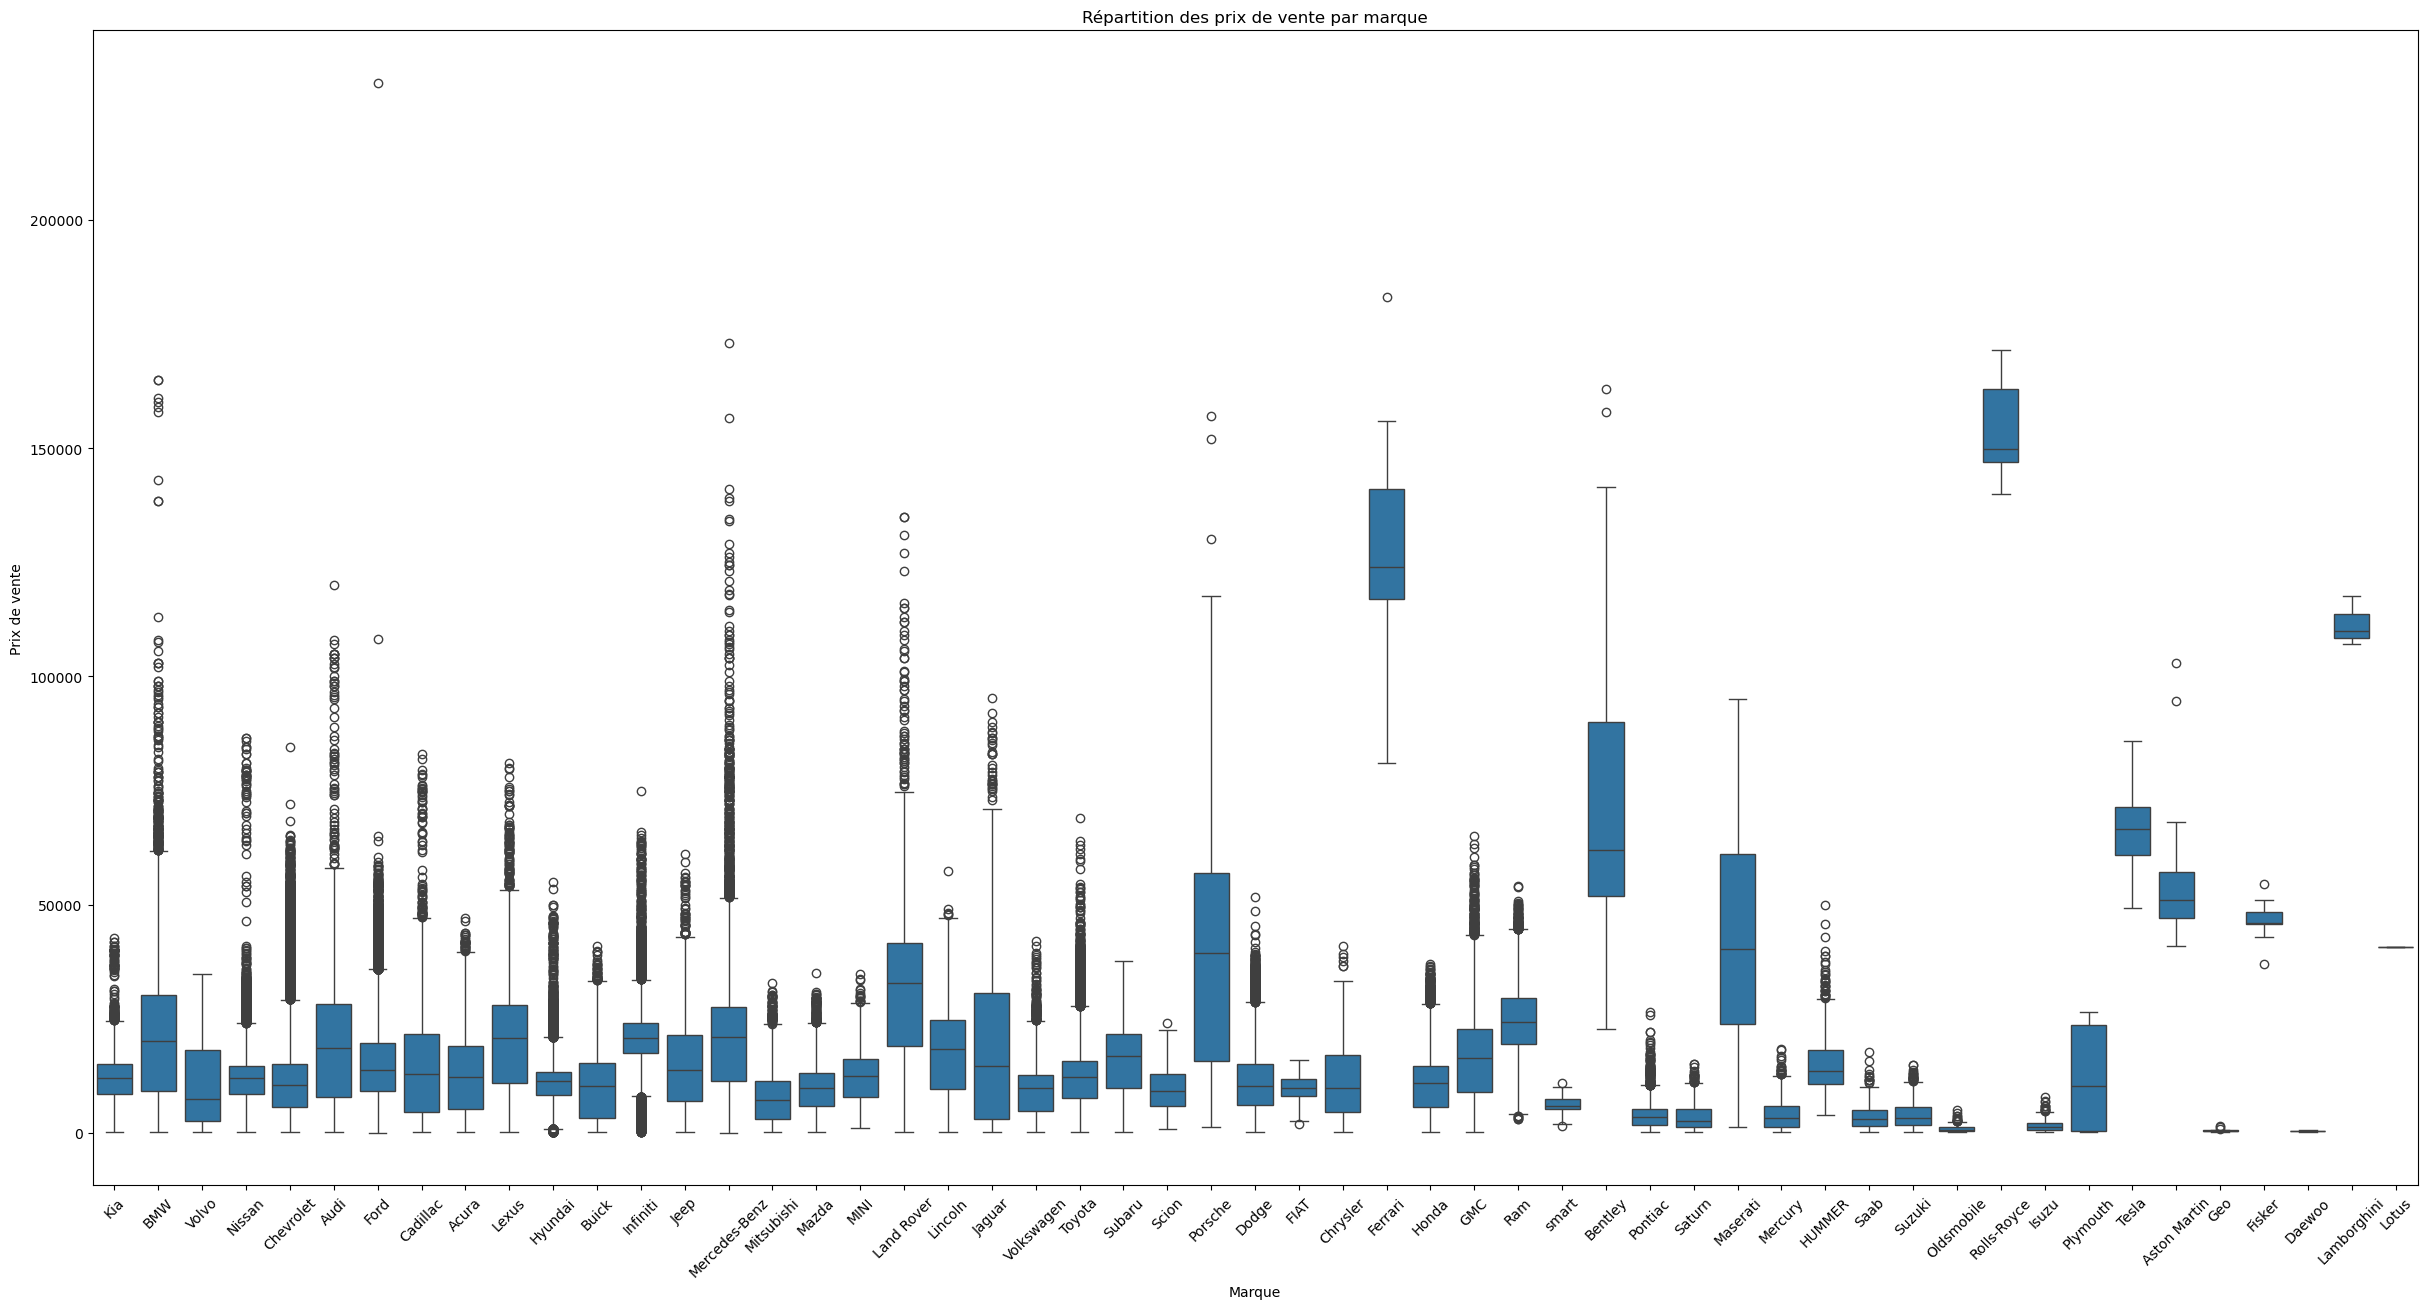

In [65]:
# Boxplot des prix de vente par marque
plt.figure(figsize=(30, 15))
sns.boxplot(data=df, x='make', y='sellingprice')
plt.title('Répartition des prix de vente par marque')
plt.xlabel('Marque')
plt.ylabel('Prix de vente')
plt.xticks(rotation=45)
plt.show()


In [66]:
stats = df.groupby('make')['sellingprice'].describe()
print(stats)


                 count           mean           std       min        25%  \
make                                                                       
Acura           4504.0   13102.470027   8876.663602     250.0    5200.00   
Aston Martin      24.0   55500.000000  14861.271524   41000.0   46975.00   
Audi            4804.0   20013.931099  15010.270693     150.0    7800.00   
BMW            17586.0   21401.835437  14640.977443     100.0    9100.00   
Bentley          105.0   72713.333333  30383.470856   22700.0   52000.00   
Buick           4471.0   10591.472601   8120.134724     100.0    3300.00   
Cadillac        6318.0   14730.017569  11989.859095     150.0    4650.00   
Chevrolet      54177.0   11865.486184   8786.630800     100.0    5700.00   
Chrysler       15137.0   10628.322719   6778.851578     100.0    4600.00   
Daewoo             2.0     450.000000    212.132034     300.0     375.00   
Dodge          27188.0   10964.561351   6447.989939     100.0    6200.00   
FIAT        

In [67]:
variance = df.groupby('make')['sellingprice'].var().sort_values(ascending=False)	
print(variance)


make
Bentley          9.231553e+08
Porsche          6.234774e+08
Ferrari          5.713051e+08
Maserati         5.160587e+08
Land Rover       4.318912e+08
Jaguar           3.581774e+08
Audi             2.253082e+08
Aston Martin     2.208574e+08
BMW              2.143582e+08
Mercedes-Benz    2.100824e+08
Cadillac         1.437567e+08
Plymouth         1.297014e+08
Lexus            1.192690e+08
Rolls-Royce      1.100586e+08
GMC              1.028574e+08
Lincoln          9.910750e+07
Tesla            9.362475e+07
Volvo            8.908867e+07
Jeep             8.608727e+07
Acura            7.879516e+07
Ram              7.747764e+07
Chevrolet        7.720488e+07
Ford             7.183005e+07
Buick            6.593659e+07
Infiniti         6.151729e+07
Subaru           5.752234e+07
Chrysler         4.595283e+07
Toyota           4.583061e+07
Honda            4.347885e+07
HUMMER           4.238516e+07
Dodge            4.157657e+07
Mazda            3.608448e+07
Mitsubishi       3.445058e+07
Nissa

In [71]:


# Définir les intervalles de prix pour chaque catégorie de budget
budget_ranges = {
    'low_budget': (0, 30000),
    'medium_low_budget': (30000, 50000),
    'medium_budget': (50000, 80000),
    'high_budget': (80000, 150000),
    'luxury_budget': (150000, np.inf)
}

# Fonction pour catégoriser le budget en fonction de `sellingprice`
def categorize_budget(price):
    for category, (low, high) in budget_ranges.items():
        if low < price <= high:
            return category
    return 'undefined'  # Au cas où il y aurait une valeur hors des plages définies

# Appliquer la fonction de catégorisation à la colonne `sellingprice`
df['buyer_budget_category'] = df['sellingprice'].apply(categorize_budget)

# Vérifiez les premières lignes pour voir les catégories assignées
print(df[['sellingprice', 'buyer_budget_category']].head())


   sellingprice buyer_budget_category
0       21500.0            low_budget
1       21500.0            low_budget
2       30000.0            low_budget
3       27750.0            low_budget
4       67000.0         medium_budget


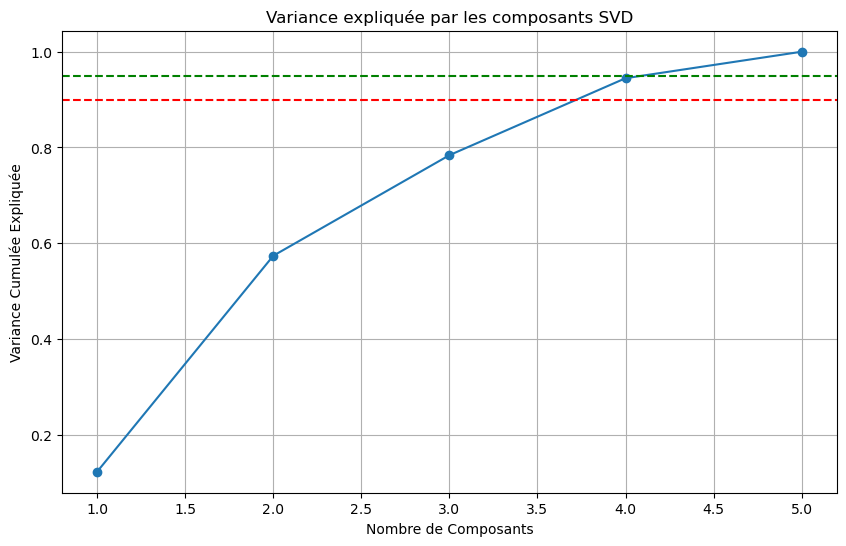

In [72]:
# Créer la table pivotante
pivot_table = pd.pivot_table(df, values='sellingprice', index='buyer_budget_category', 
                             columns='vehicle', aggfunc='mean').fillna(0)


# Ajuster SVD avec un nombre maximum de composants
svd = TruncatedSVD(n_components=700)  # Vous pouvez choisir un nombre élevé pour commencer
svd.fit(pivot_table)

# Calculer la variance expliquée
explained_variance = svd.explained_variance_ratio_.cumsum()

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Variance expliquée par les composants SVD')
plt.xlabel('Nombre de Composants')
plt.ylabel('Variance Cumulée Expliquée')
plt.grid()
plt.axhline(y=0.9, color='r', linestyle='--')  # Ligne pour 90%
plt.axhline(y=0.95, color='g', linestyle='--')  # Ligne pour 95%
plt.show()


In [73]:

# Créer la table pivotante
pivot_table = pd.pivot_table(df, values='sellingprice', index='buyer_budget_category', 
                             columns='vehicle', aggfunc='mean').fillna(0)

# Appliquer SVD sur la table pivotante
svd = TruncatedSVD(n_components=4)  # Ajuster le nombre de composants si nécessaire
svd_matrix = svd.fit_transform(pivot_table)

# Recréer un DataFrame à partir de la matrice SVD
svd_df = pd.DataFrame(svd_matrix, index=pivot_table.index)

def recommend_vehicles_for_budget(budget_category, svd_df, pivot_table, df, top_n=5):
    # Définir les intervalles de prix pour chaque catégorie de budget
    budget_ranges = {
        'low_budget': (0, 30000),
        'medium_low_budget': (30000, 50000),
        'medium_budget': (50000, 80000),
        'high_budget': (80000, 150000),
        'luxury_budget': (150000, np.inf)
    }

    # Obtenir les limites de l'intervalle pour le budget sélectionné
    min_price, max_price = budget_ranges[budget_category]

    # Filtrer les véhicules dans cet intervalle de prix
    filtered_vehicles = df[(df['sellingprice'] > min_price) & (df['sellingprice'] < max_price)]

    # Créer une nouvelle table pivotante basée sur les véhicules filtrés
    filtered_pivot_table = pivot_table.loc[:, pivot_table.columns.isin(filtered_vehicles['vehicle'])]

    # Appliquer SVD sur la table filtrée
    svd = TruncatedSVD(n_components=4)  # Ajuster le nombre de composants si nécessaire
    svd_matrix_filtered = svd.fit_transform(filtered_pivot_table)

    # Recréer un DataFrame à partir de la matrice SVD filtrée
    svd_df_filtered = pd.DataFrame(svd_matrix_filtered, index=filtered_pivot_table.index)

    # Calculer les similarités
    budget_vector = svd_df_filtered.loc[budget_category].values.reshape(1, -1)
    similarities = cosine_similarity(svd_matrix_filtered, budget_vector).flatten()

    # Obtenir les indices des véhicules les plus proches (similaires)
    recommended_vehicles_idx = np.argsort(similarities)[::-1][:top_n]
    recommended_vehicles = filtered_pivot_table.columns[recommended_vehicles_idx]

    return recommended_vehicles

# Recommander des véhicules pour chaque catégorie de budget
recommended_vehicles_low = recommend_vehicles_for_budget('low_budget', svd_df, pivot_table, df, top_n=5)
recommended_vehicles_medium = recommend_vehicles_for_budget('medium_budget', svd_df, pivot_table, df, top_n=5)
recommended_vehicles_high = recommend_vehicles_for_budget('high_budget', svd_df, pivot_table, df, top_n=5)

# Afficher les recommandations
print("Véhicules recommandés pour un budget bas :", recommended_vehicles_low)
print("Véhicules recommandés pour un budget moyen :", recommended_vehicles_medium)
print("Véhicules recommandés pour un budget élevé :", recommended_vehicles_high)

# Fonction pour afficher une heatmap pour les véhicules recommandés uniquement
def plot_recommendation_heatmap(recommended_vehicles, pivot_table, title):
    plt.figure(figsize=(12, 6))
    # Filtrer la table pivotante uniquement pour les véhicules recommandés
    filtered_pivot_table = pivot_table.loc[:, pivot_table.columns.isin(recommended_vehicles)]
    
    # Tracer la heatmap
    sns.heatmap(filtered_pivot_table, cmap='coolwarm', annot=True, fmt=".0f", cbar_kws={'label': 'Prix moyen'}, linewidths=0.5)
    plt.title(title)
    plt.xlabel('Véhicule')
    plt.ylabel('Catégorie de budget')
    plt.xticks(rotation=50)
    plt.show()




Véhicules recommandés pour un budget bas : Index(['Acura ILX', 'Acura MDX', 'Acura Legend', 'Acura CL', 'Acura Integra'], dtype='object', name='vehicle')
Véhicules recommandés pour un budget moyen : Index(['Audi A7', 'Aston Martin V8 Vantage', 'Audi A8', 'Aston Martin DB9',
       'Audi A6'],
      dtype='object', name='vehicle')
Véhicules recommandés pour un budget élevé : Index(['Aston Martin Rapide', 'Audi S8', 'Audi R8', 'BMW 4 Series',
       'Audi RS 7'],
      dtype='object', name='vehicle')


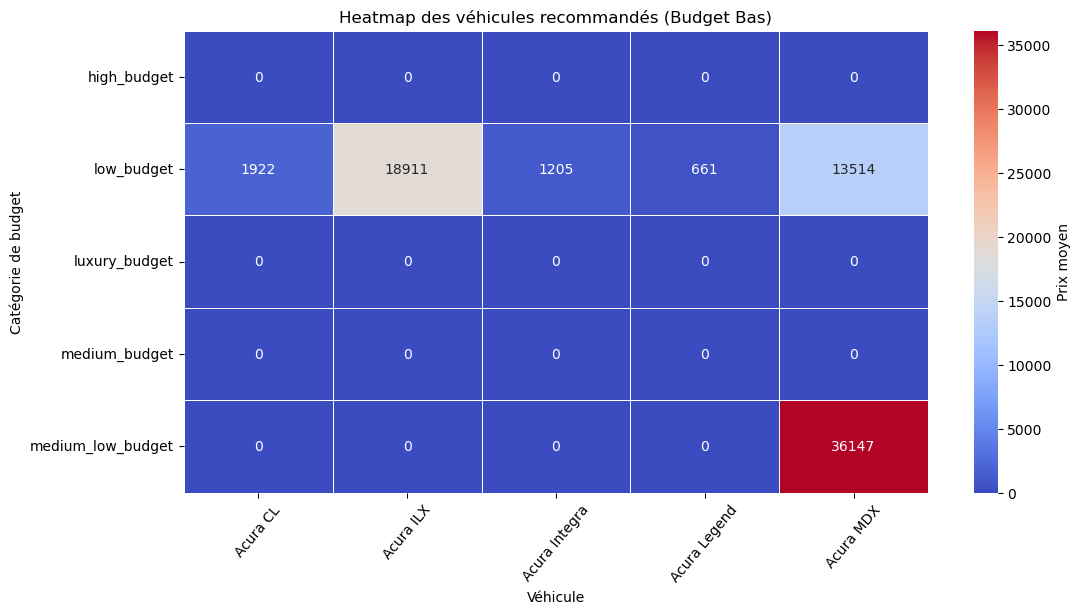

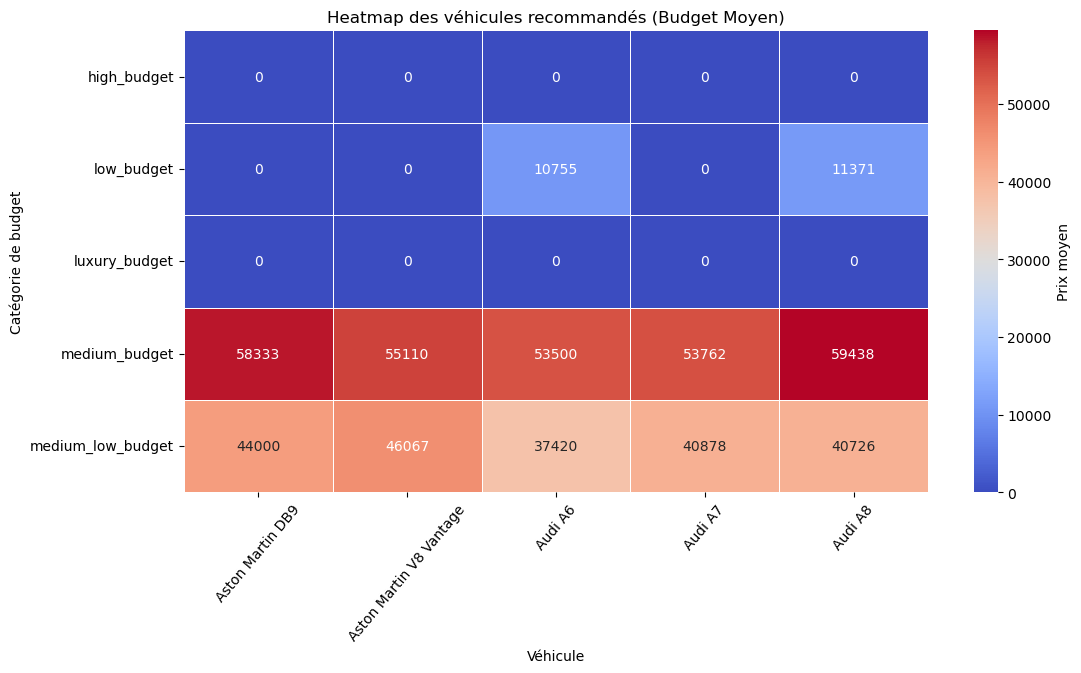

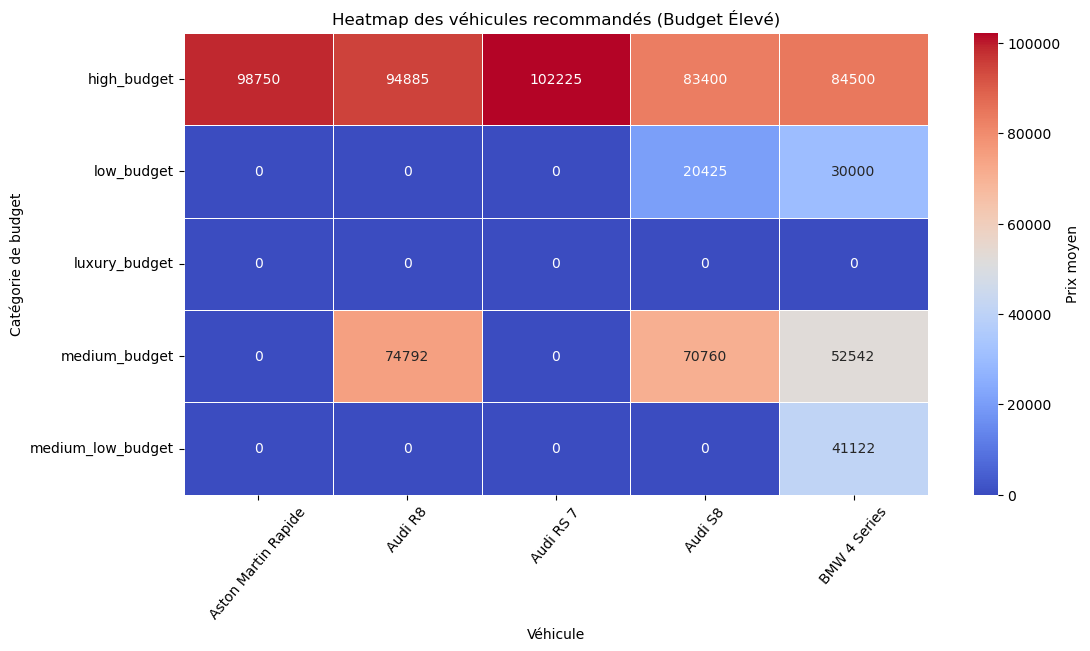

In [74]:
# Visualiser la heatmap pour chaque catégorie de budget
plot_recommendation_heatmap(recommended_vehicles_low, pivot_table, 'Heatmap des véhicules recommandés (Budget Bas)')
plot_recommendation_heatmap(recommended_vehicles_medium, pivot_table, 'Heatmap des véhicules recommandés (Budget Moyen)')
plot_recommendation_heatmap(recommended_vehicles_high, pivot_table, 'Heatmap des véhicules recommandés (Budget Élevé)')

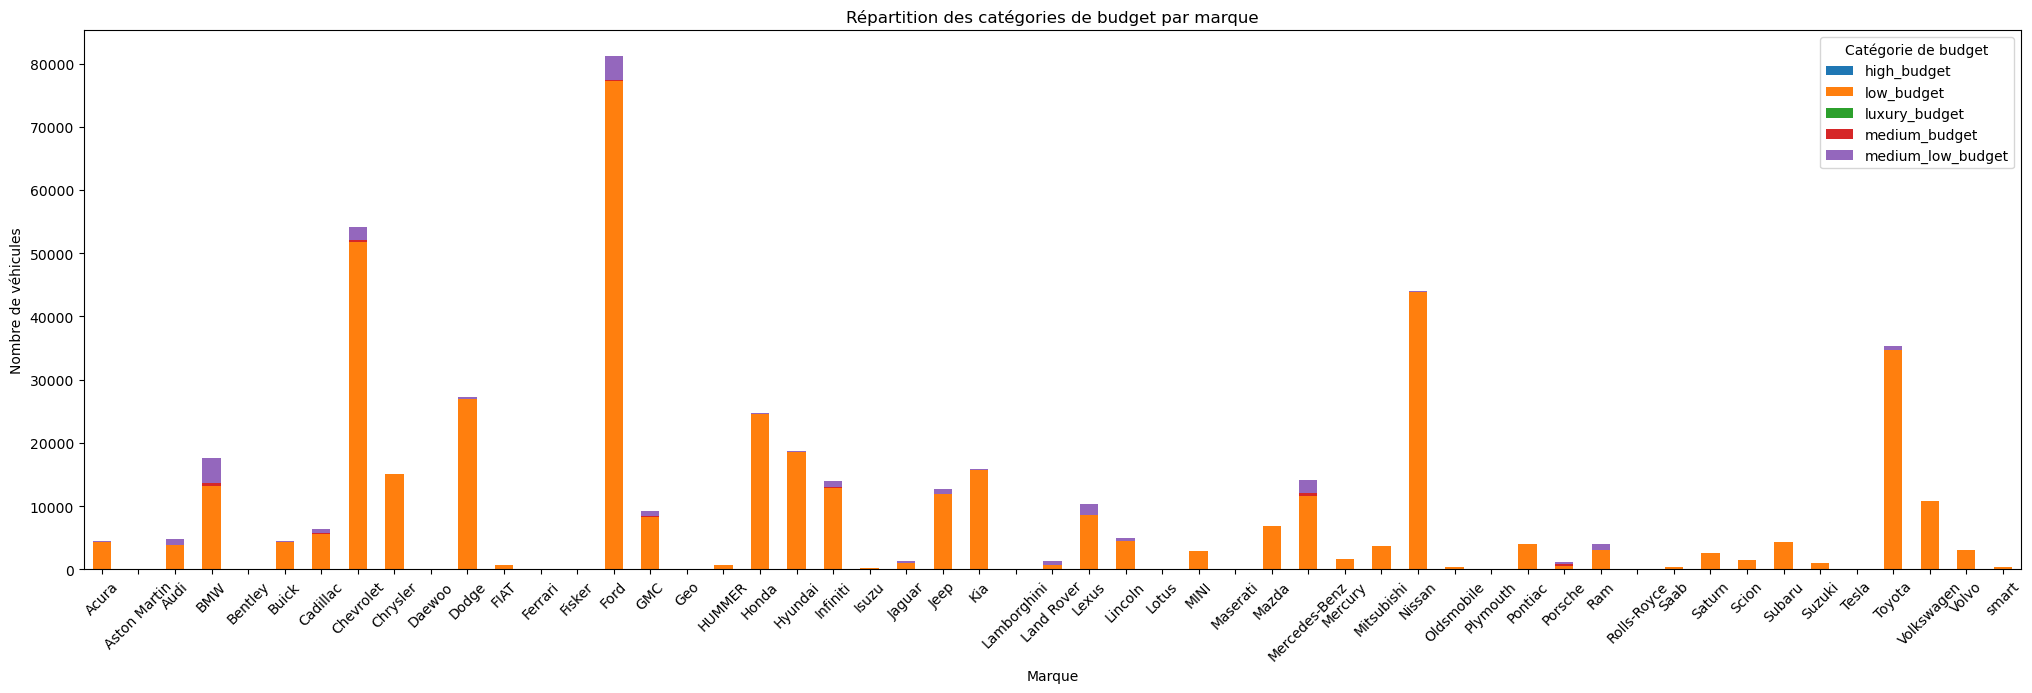

In [95]:
# Créer une table de contingence pour les marques et les catégories de budget
budget_counts = df.groupby(['make', 'buyer_budget_category']).size().unstack(fill_value=0)

# Diagramme à barres empilées des catégories de budget par marque
budget_counts.plot(kind='bar', stacked=True, figsize=(25, 7))
plt.title('Répartition des catégories de budget par marque')
plt.xlabel('Marque')
plt.ylabel('Nombre de véhicules')
plt.legend(title='Catégorie de budget')
plt.xticks(rotation=45)
plt.show()


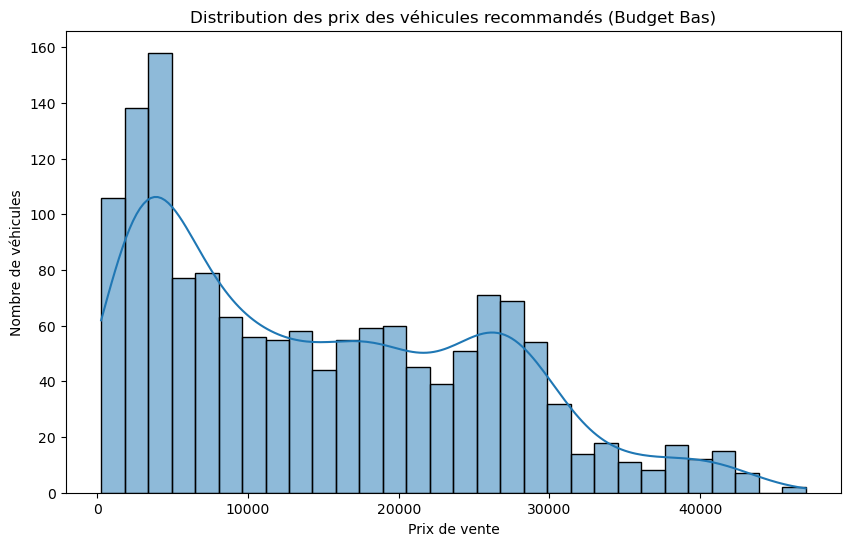

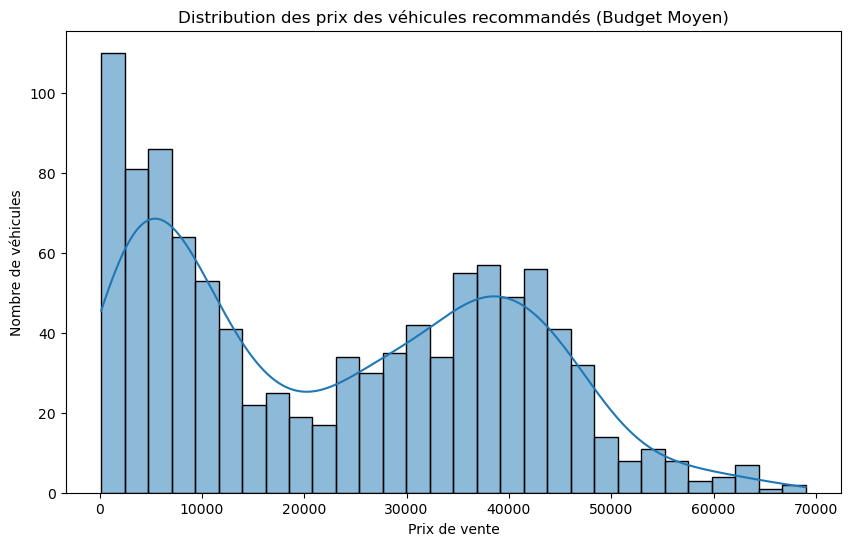

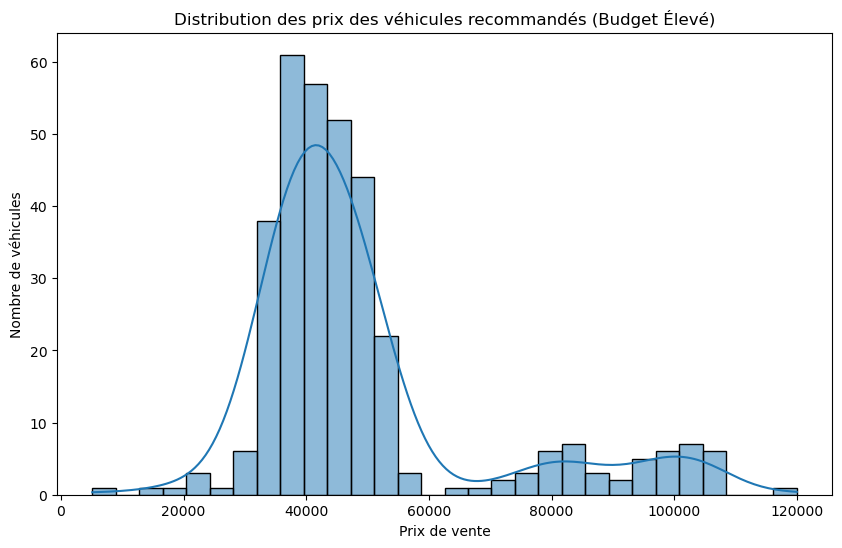

In [76]:
# Visualisation supplémentaire : Distribution des prix des véhicules recommandés
def plot_recommendation_distribution(recommended_vehicles, df, title):
    plt.figure(figsize=(10, 6))
    filtered_data = df[df['vehicle'].isin(recommended_vehicles)]
    sns.histplot(filtered_data['sellingprice'], bins=30, kde=True)
    plt.title(title)
    plt.xlabel('Prix de vente')
    plt.ylabel('Nombre de véhicules')
    plt.show()

# Plotting distribution of the recommended vehicles for each budget category
plot_recommendation_distribution(recommended_vehicles_low, df, 'Distribution des prix des véhicules recommandés (Budget Bas)')
plot_recommendation_distribution(recommended_vehicles_medium, df, 'Distribution des prix des véhicules recommandés (Budget Moyen)')
plot_recommendation_distribution(recommended_vehicles_high, df, 'Distribution des prix des véhicules recommandés (Budget Élevé)')

In [91]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Fonction de recommandation affinée par catégorie
def recommend_vehicles_for_budget_and_category(budget_category, vehicle_category, svd_df, pivot_table, df, top_n=5, diversify=False):
    # Filtrer les véhicules dans la même catégorie
    filtered_df = df[df['body'].str.contains(vehicle_category, case=False, na=False)]
    
    # Vérifier si le filtrage est trop restrictif
    if filtered_df.empty:
        print(f"Avertissement : Aucun véhicule trouvé pour la catégorie {vehicle_category}.")
        return []

    # Créer une table pivotante pour les véhicules de la même catégorie
    filtered_pivot_table = pivot_table.loc[:, pivot_table.columns.isin(filtered_df['vehicle'])]

    # Vérifier que la table pivotante n'est pas vide
    if filtered_pivot_table.empty:
        print(f"Avertissement : La table pivotante est vide pour {vehicle_category} et {budget_category}.")
        return []

    # Appliquer SVD sur la table filtrée
    svd = TruncatedSVD(n_components=4)  # Ajustez le nombre de composants si nécessaire
    try:
        svd_matrix_filtered = svd.fit_transform(filtered_pivot_table)
    except ValueError:
        print("Erreur : SVD n'a pas pu être appliqué car la table pivotante n'a pas assez de données.")
        return []

    # Recréer un DataFrame à partir de la matrice SVD filtrée
    svd_df_filtered = pd.DataFrame(svd_matrix_filtered, index=filtered_pivot_table.index)

    # Vérifier que le budget_category est bien dans l'index
    if budget_category not in svd_df_filtered.index:
        print(f"Avertissement : Le budget {budget_category} n'est pas dans la table SVD filtrée.")
        return []

    # Calculer les similarités
    budget_vector = svd_df_filtered.loc[budget_category].values.reshape(1, -1)
    similarities = cosine_similarity(svd_matrix_filtered, budget_vector).flatten()

    # Obtenir les indices des véhicules les plus proches (similaires)
    recommended_vehicles_idx = np.argsort(similarities)[::-1][:top_n]
    recommended_vehicles = filtered_pivot_table.columns[recommended_vehicles_idx]

    # Diversification : ajuster si demandé
    if diversify:
        # Mélanger légèrement les recommandations pour inclure différents types
        recommended_vehicles = np.random.choice(filtered_pivot_table.columns, top_n, replace=False)

    return recommended_vehicles


Recommandations pour low_budget - SUV : ['HUMMER H1' 'Volvo XC60' 'Ford Explorer' 'Lexus RX 350' 'Porsche Cayenne']
Échantillon de véhicules disponibles : ['Kia Sorento' 'Audi Q5' 'Audi SQ5' 'Chevrolet Suburban' 'BMW X6'
 'Lexus RX 350' 'BMW X1' 'Buick Enclave' 'Acura MDX' 'Cadillac SRX']
Recommandations pour low_budget - Sedan : ['Ford Escort' 'BMW 7 Series' 'Audi A6' 'Infiniti Q70' 'Buick Verano']
Échantillon de véhicules disponibles : ['BMW 3 Series' 'Volvo S60' 'BMW 6 Series Gran Coupe' 'Nissan Altima'
 'BMW M5' 'Chevrolet Cruze' 'Audi A4' 'Audi A6' 'Kia Optima' 'Ford Fusion']
Avertissement: Peu de diversité pour low_budget et Truck
Recommandations pour low_budget - Coupe : ['Hyundai Genesis Coupe' 'Ford Escort' 'Pontiac G6' 'Pontiac Grand Am'
 'Honda Accord']
Échantillon de véhicules disponibles : ['Chevrolet Camaro' 'Audi S5' 'Cadillac ELR' 'BMW 6 Series' 'Audi TTS'
 'BMW 4 Series' 'Infiniti G Coupe' 'Hyundai Elantra Coupe'
 'Hyundai Genesis Coupe' 'Mercedes-Benz C-Class']
Recomm

C:\Users\amira\AppData\Local\Temp\ipykernel_10528\4216442461.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=vehicles, x=np.arange(len(vehicles)), ax=ax, palette="viridis")  # Ajustez x si vous avez une métrique de similarité
C:\Users\amira\AppData\Local\Temp\ipykernel_10528\4216442461.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(vehicles, rotation=45, ha='right')
C:\Users\amira\AppData\Local\Temp\ipykernel_10528\4216442461.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=vehicles, x=np.arange(len(vehicles)), ax=ax, palette="viridis")  # Ajustez x si vous avez une mét

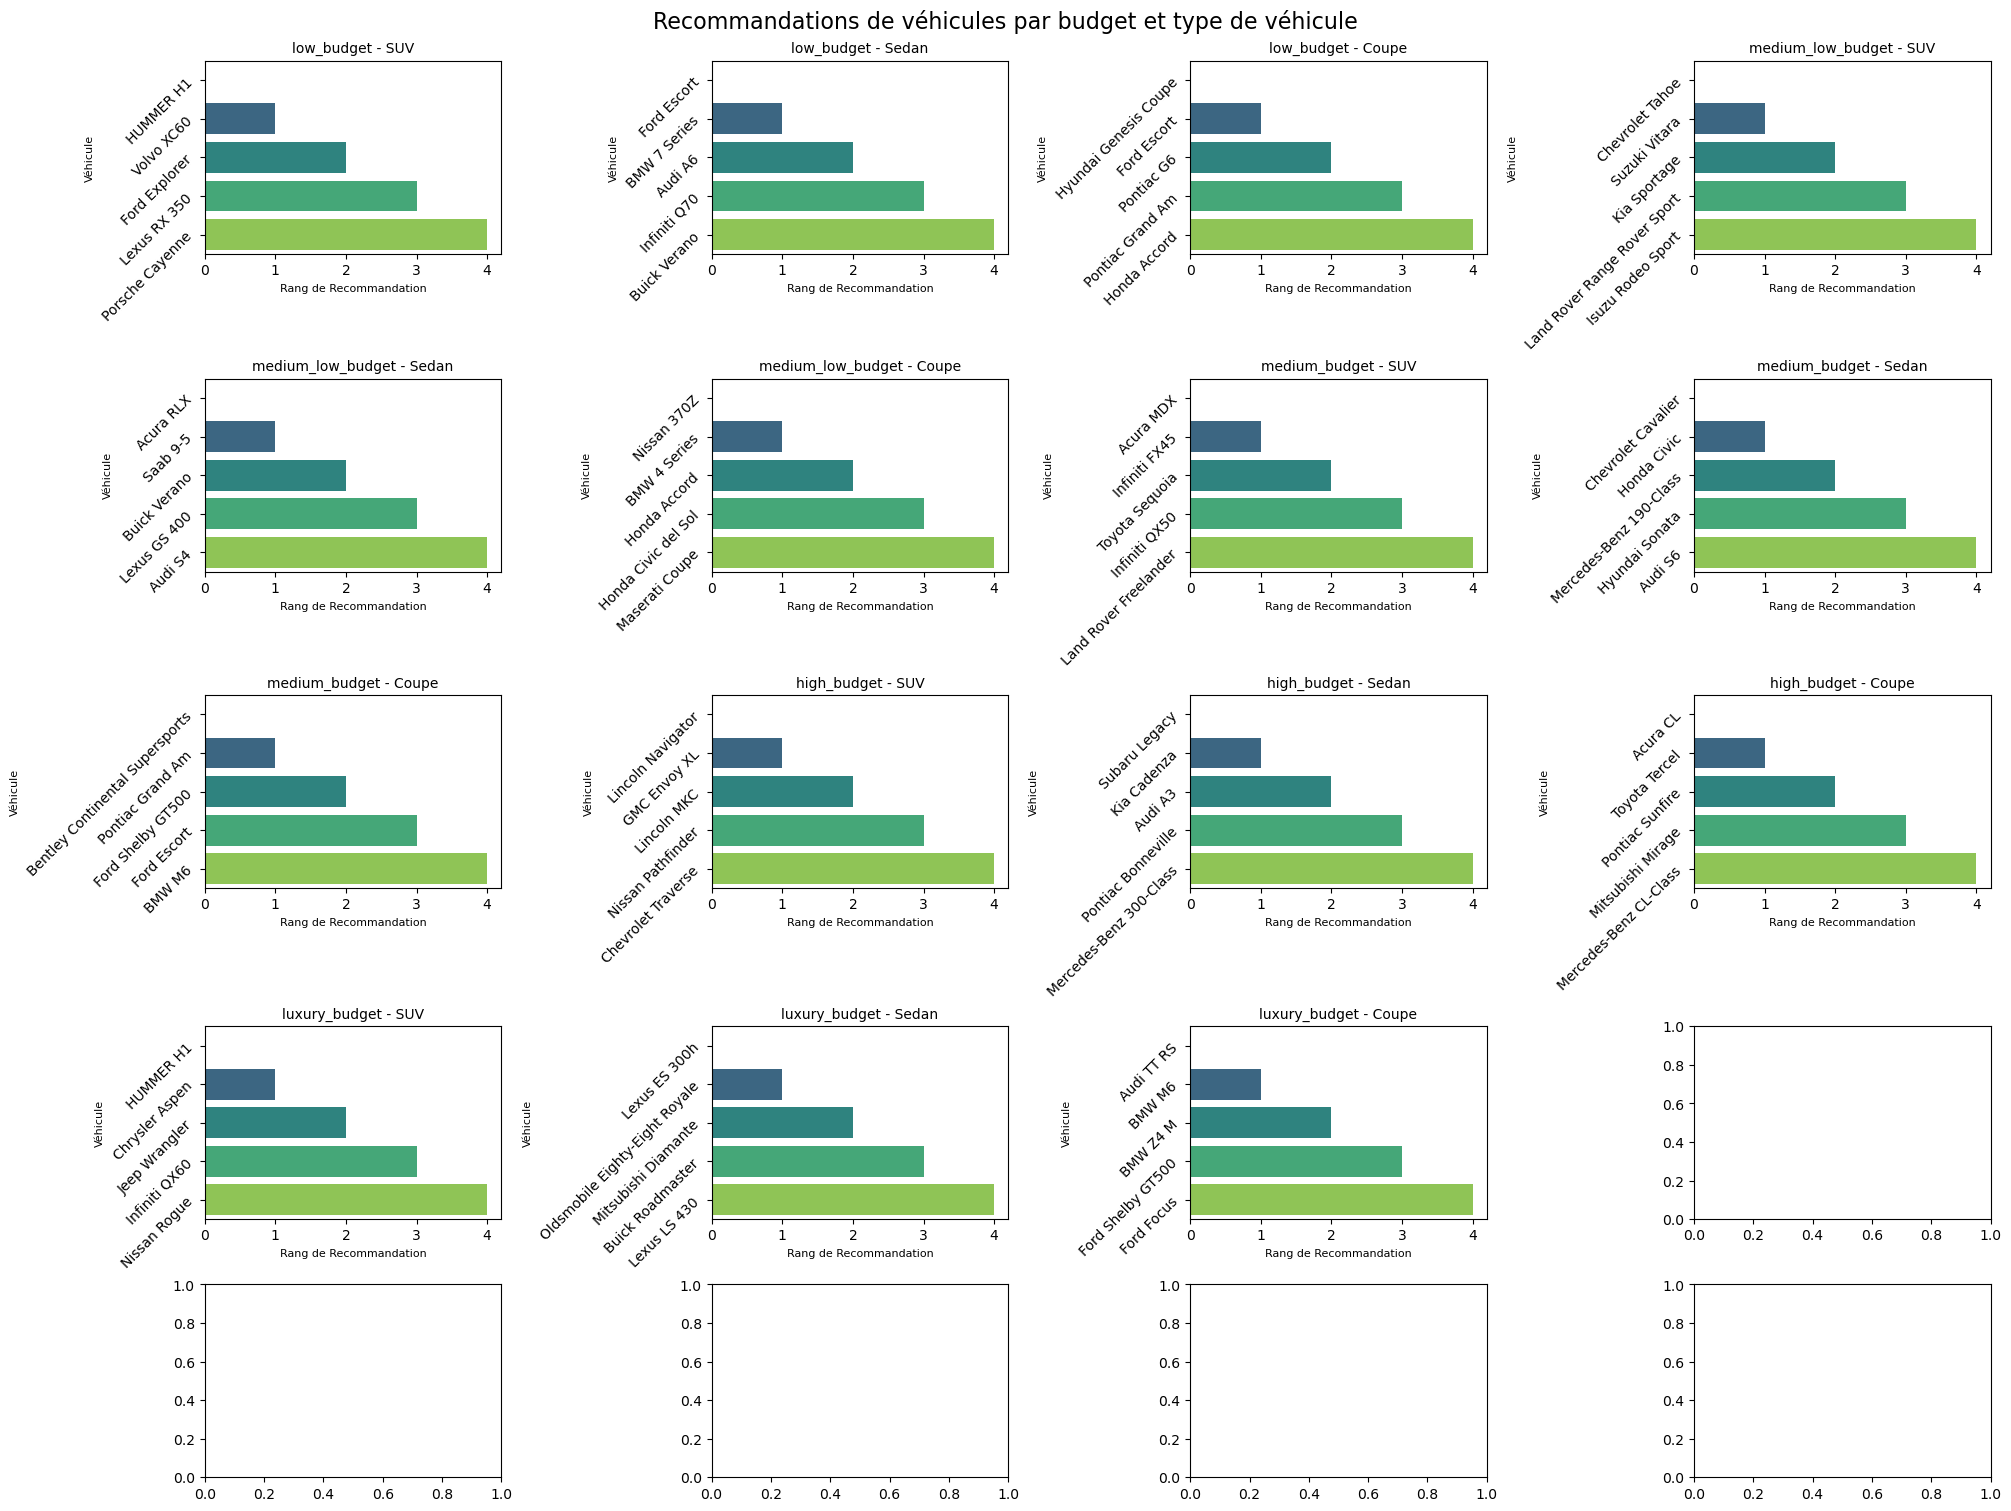

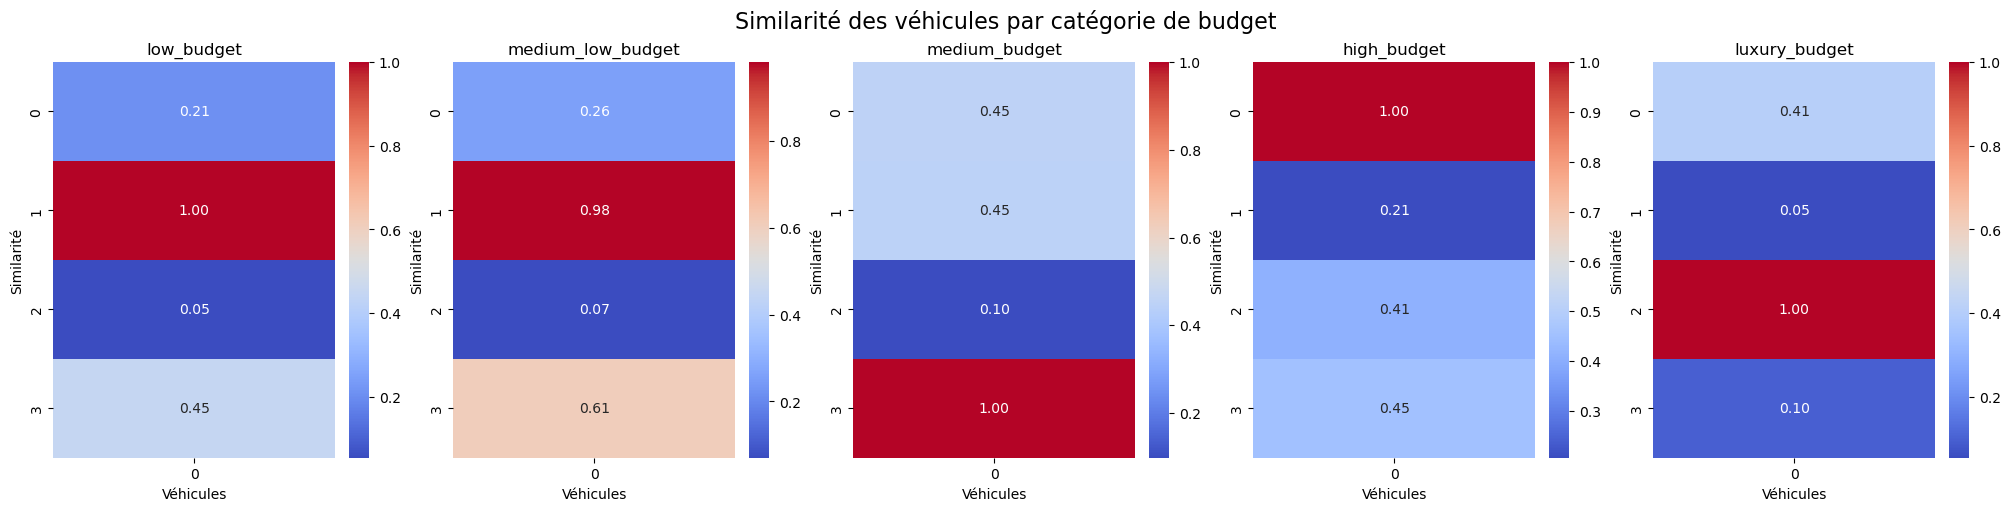

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Initialisation des paramètres
budget_categories = ['low_budget', 'medium_low_budget', 'medium_budget', 'high_budget', 'luxury_budget']
vehicle_categories = ['SUV', 'Sedan', 'Truck', 'Coupe']  # Remplacez par les catégories réelles dans votre dataset

# Dictionnaire pour stocker les recommandations
recommendations = {}

# Génération des recommandations et stockage dans le dictionnaire
for budget in budget_categories:
    for vehicle_cat in vehicle_categories:
        try:
            # Filtrer les données pour la catégorie de véhicule, mais en permettant une tolérance pour la diversité
            filtered_df = df[(df['body'] == vehicle_cat) | (df['body'].str.contains(vehicle_cat, case=False, na=False))]
            filtered_pivot_table = pivot_table.loc[:, pivot_table.columns.isin(filtered_df['vehicle'])]
            
            # Vérifier la diversité des véhicules
            if filtered_pivot_table.empty or len(filtered_df['vehicle'].unique()) < 5:
                print(f"Avertissement: Peu de diversité pour {budget} et {vehicle_cat}")
                continue

            # Génération des recommandations avec une logique améliorée pour la diversité
            recommended_vehicles = recommend_vehicles_for_budget_and_category(
                budget, vehicle_cat, svd_df, pivot_table, df, top_n=5, diversify=True
            )
            recommendations[(budget, vehicle_cat)] = recommended_vehicles
            
            # Affichage des résultats intermédiaires pour vérifier la diversité
            print(f"Recommandations pour {budget} - {vehicle_cat} : {recommended_vehicles}")
            print("Échantillon de véhicules disponibles :", filtered_df['vehicle'].unique()[:10])

        except KeyError as e:
            print(f"Erreur pour {budget} et {vehicle_cat} : {e}")

# Affichage des recommandations
fig, axes = plt.subplots(len(budget_categories), len(vehicle_categories), figsize=(20, 15), constrained_layout=True)
fig.suptitle("Recommandations de véhicules par budget et type de véhicule", fontsize=16)

for (budget, vehicle_cat), ax in zip(recommendations, axes.flatten()):
    vehicles = recommendations[(budget, vehicle_cat)]
    sns.barplot(y=vehicles, x=np.arange(len(vehicles)), ax=ax, palette="viridis")  # Ajustez x si vous avez une métrique de similarité
    ax.set_title(f"{budget} - {vehicle_cat}", fontsize=10)
    ax.set_xlabel("Rang de Recommandation", fontsize=8)
    ax.set_ylabel("Véhicule", fontsize=8)
    ax.set_yticklabels(vehicles, rotation=45, ha='right')

# Heatmap de similarité par budget
fig, axes = plt.subplots(1, len(budget_categories), figsize=(20, 5), constrained_layout=True)
fig.suptitle("Similarité des véhicules par catégorie de budget", fontsize=16)

for i, budget in enumerate(budget_categories):
    try:
        budget_vector = svd_df.loc[budget].values.reshape(1, -1)
        similarities = cosine_similarity(svd_matrix, budget_vector).flatten()
        
        # Reshape en supposant qu'il y a autant de catégories de véhicules que nécessaire
        similarities_reshaped = similarities.reshape(-1, 1)[:len(vehicle_categories)]
        sns.heatmap(similarities_reshaped, ax=axes[i], cmap='coolwarm', cbar=True, annot=True, fmt=".2f")
        axes[i].set_title(budget)
        axes[i].set_xlabel("Véhicules")
        axes[i].set_ylabel("Similarité")

    except KeyError:
        print(f"Erreur de similarité pour la catégorie de budget : {budget}")

plt.show()


In [ ]:
# Exemple d'utilisation
budget_category = 'medium_budget'  # Remplacez par la catégorie de budget de l'utilisateur
vehicle_category = 'SUV'  # Remplacez par la catégorie de véhicule recherchée par l'utilisateur
recommended_vehicles = recommend_vehicles_for_budget_and_category(budget_category, vehicle_category, svd_df, pivot_table, df, top_n=5)

print("Véhicules recommandés pour un budget moyen et catégorie SUV :", recommended_vehicles)


In [78]:
print(df.columns)


Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'sellingprice', 'saledate', 'vehicle',
       'buyer_budget_category'],
      dtype='object')


# Clustering 

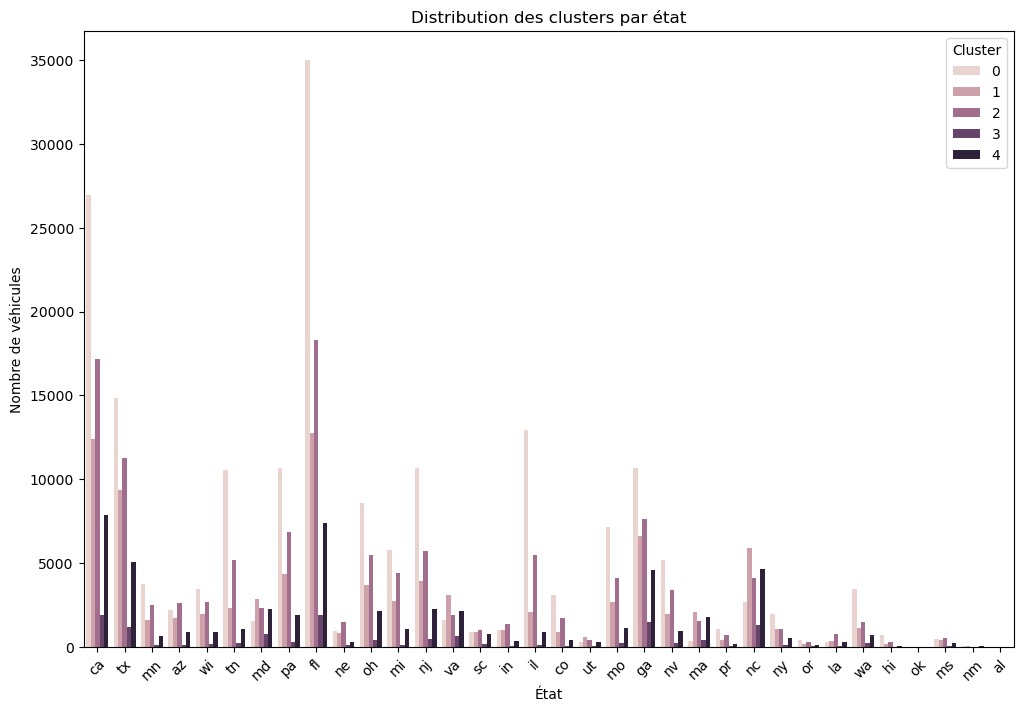

In [8]:
from sklearn.cluster import KMeans
import pandas as pd

# Supposons que 'sellingprice', 'odometer', et 'condition' sont les colonnes à inclure dans le clustering
features = df[['sellingprice', 'odometer', 'condition']]

# Appliquer K-Means pour diviser les ventes par clusters basés sur les caractéristiques de véhicules
kmeans = KMeans(n_clusters=5, random_state=42)  # Ajuster le nombre de clusters selon les besoins
df['cluster'] = kmeans.fit_predict(features)

# Visualisation des clusters par état
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.countplot(x='state', hue='cluster', data=df)
plt.title("Distribution des clusters par état")
plt.xlabel("État")
plt.ylabel("Nombre de véhicules")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.show()


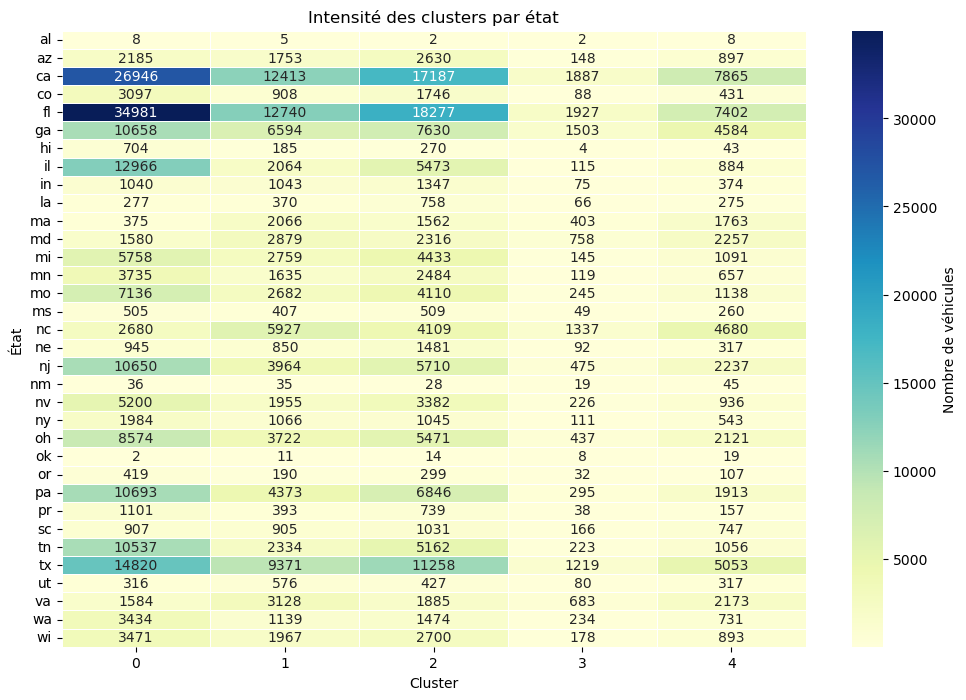

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Regrouper les données par état et cluster pour obtenir le nombre de véhicules
df_clustered = df.groupby(['state', 'cluster']).size().unstack(fill_value=0)

# Créer une heatmap de l’intensité des clusters par état
plt.figure(figsize=(12, 8))
sns.heatmap(df_clustered, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5, cbar_kws={'label': 'Nombre de véhicules'})
plt.title("Intensité des clusters par état")
plt.xlabel("Cluster")
plt.ylabel("État")
plt.show()


Statistiques descriptives par cluster:
         sellingprice                                               odometer  \
                 mean   median           std    min       max           mean   
cluster                                                                        
0        19725.860204  17500.0  10011.310507    1.0  230000.0   23358.208168   
1         8126.882977   7100.0   5236.276455  100.0   57000.0   99378.776569   
2        13904.769449  12300.0   6675.452036  100.0  108200.0   56003.679010   
3         2769.650781   1900.0   2826.315627  100.0   26800.0  223609.054531   
4         4381.102290   3400.0   3700.852666  100.0   38750.0  148113.336273   

                                                     condition         \
           median           std       min       max       mean median   
cluster                                                                 
0         23826.0  10174.465661       1.0   49514.0  34.246709   39.0   
1         98579.0  13003.534

C:\Users\amira\AppData\Local\Temp\ipykernel_27308\1106901123.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='sellingprice', data=df, palette=cluster_colors)
C:\Users\amira\AppData\Local\Temp\ipykernel_27308\1106901123.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='odometer', data=df, palette=cluster_colors)
C:\Users\amira\AppData\Local\Temp\ipykernel_27308\1106901123.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='condition', data=df, palette=cluster_colors)


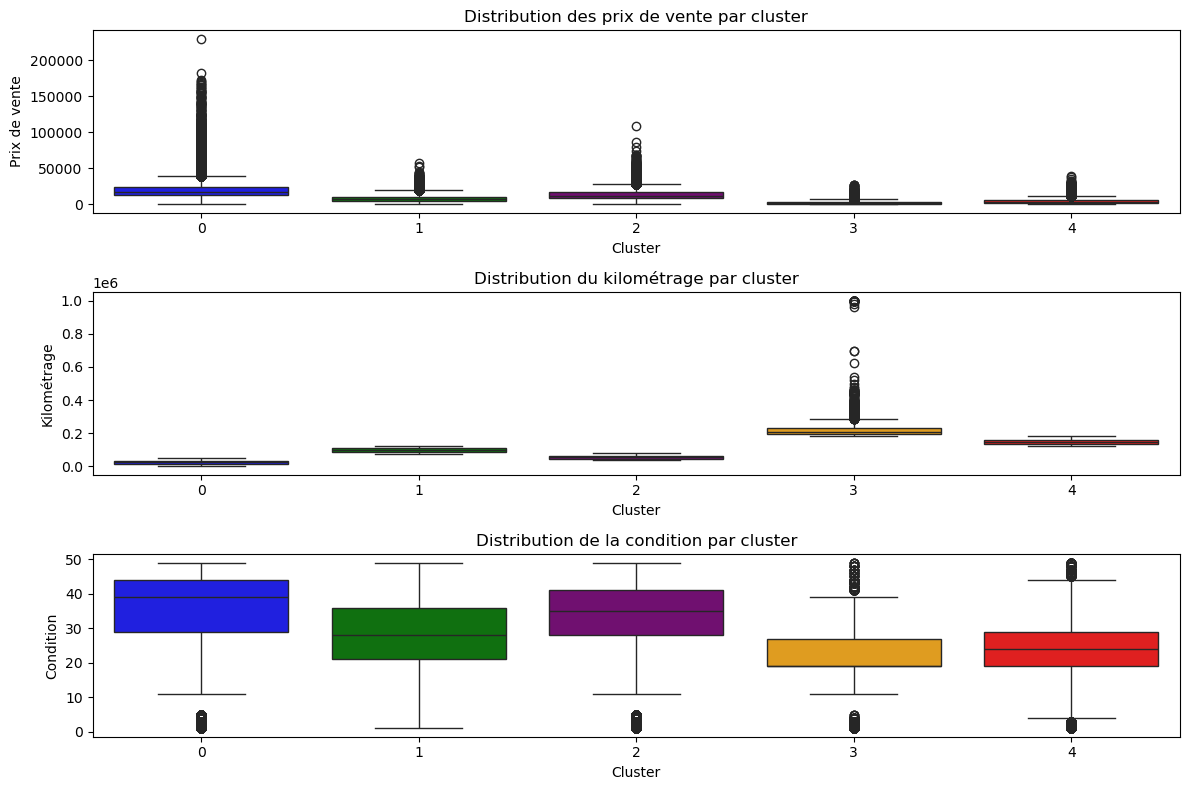

   sellingprice  odometer  condition  cluster  \
0       21500.0   16639.0        5.0        0   
1       21500.0    9393.0        5.0        0   
2       30000.0    1331.0       45.0        0   
3       27750.0   14282.0       41.0        0   
4       67000.0    2641.0       43.0        0   

                                    cluster_label  
0  Bas prix, kilométrage élevé, condition moyenne  
1  Bas prix, kilométrage élevé, condition moyenne  
2  Bas prix, kilométrage élevé, condition moyenne  
3  Bas prix, kilométrage élevé, condition moyenne  
4  Bas prix, kilométrage élevé, condition moyenne  


In [21]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des caractéristiques pour le clustering
features = df[['sellingprice', 'odometer', 'condition']]

# Appliquer K-Means pour diviser les ventes par clusters basés sur les caractéristiques de véhicules
kmeans = KMeans(n_clusters=5, random_state=42)  # Ajuster le nombre de clusters selon les besoins
df['cluster'] = kmeans.fit_predict(features)

# 1. Calcul des statistiques descriptives par cluster
cluster_summary = df.groupby('cluster')[['sellingprice', 'odometer', 'condition']].agg(['mean', 'median', 'std', 'min', 'max'])
print("Statistiques descriptives par cluster:")
print(cluster_summary)

# Définir la palette de couleurs pour les clusters, correspondante aux couleurs utilisées sur la carte
cluster_colors = ['blue', 'green', 'purple', 'orange', 'red']

# 2. Visualiser la distribution des caractéristiques par cluster avec la palette personnalisée
plt.figure(figsize=(12, 8))

# Distribution des prix de vente
plt.subplot(3, 1, 1)
sns.boxplot(x='cluster', y='sellingprice', data=df, palette=cluster_colors)
plt.title("Distribution des prix de vente par cluster")
plt.xlabel("Cluster")
plt.ylabel("Prix de vente")

# Distribution du kilométrage
plt.subplot(3, 1, 2)
sns.boxplot(x='cluster', y='odometer', data=df, palette=cluster_colors)
plt.title("Distribution du kilométrage par cluster")
plt.xlabel("Cluster")
plt.ylabel("Kilométrage")

# Distribution de la condition
plt.subplot(3, 1, 3)
sns.boxplot(x='cluster', y='condition', data=df, palette=cluster_colors)
plt.title("Distribution de la condition par cluster")
plt.xlabel("Cluster")
plt.ylabel("Condition")

plt.tight_layout()
plt.show()

# 3. Ajouter des labels descriptifs pour chaque cluster basé sur les moyennes des caractéristiques
def label_cluster(row):
    cluster = row['cluster']
    if cluster == 0:
        return 'Bas prix, kilométrage élevé, condition moyenne'
    elif cluster == 1:
        return 'Prix moyen, faible kilométrage, bonne condition'
    elif cluster == 2:
        return 'Haut de gamme, prix élevé, excellente condition'
    elif cluster == 3:
        return 'Économique, très bas prix, kilométrage variable'
    elif cluster == 4:
        return 'Occasion, bon état, kilométrage modéré'
    else:
        return 'Non défini'

df['cluster_label'] = df.apply(label_cluster, axis=1)

# Afficher les premières lignes avec les labels de cluster pour vérifier
print(df[['sellingprice', 'odometer', 'condition', 'cluster', 'cluster_label']].head())


#### Interprétation des Clusters
- Cluster 0 (Bleu) : Véhicules abordables, bien entretenus, avec un faible kilométrage. Potentiellement des véhicules d’occasion récents.
- Cluster 1 (Vert) : Véhicules de gamme légèrement supérieure au cluster bleu, en bon état, mais peut-être un peu plus anciens.
- Cluster 2 (Violet) : Véhicules de gamme moyenne avec faible kilométrage et bonne condition.
- Cluster 3 (Orange) : Véhicules économiques avec des prix bas à modérés, un kilométrage élevé et une condition moyenne. Ce cluster semble représenter des véhicules plus usés ou plus anciens.
- Cluster 4 (Rouge) : Véhicules d’occasion en bon état, avec des prix et un kilométrage modérés.

In [19]:
import folium
from folium import Circle
import pandas as pd

# Exemple de dictionnaire de centroïdes des états
state_centroids = {
    'AL': [32.806671, -86.791130],
    'AK': [61.370716, -152.404419],
    'AZ': [33.729759, -111.431221],
    'AR': [34.969704, -92.373123],
    'CA': [36.116203, -119.681564],
    'CO': [39.059811, -105.311104],
    'CT': [41.597782, -72.755371],
    'DE': [39.318523, -75.507141],
    'FL': [27.766279, -81.686783],
    'GA': [33.040619, -83.643074],
    'HI': [21.094318, -157.498337],
    'ID': [44.240459, -114.478828],
    'IL': [40.349457, -88.986137],
    'IN': [39.849426, -86.258278],
    'IA': [42.011539, -93.210526],
    'KS': [38.526600, -96.726486],
    'KY': [37.668140, -84.670067],
    'LA': [31.169546, -91.867805],
    'ME': [44.693947, -69.381927],
    'MD': [39.063946, -76.802101],
    'MA': [42.230171, -71.530106],
    'MI': [43.326618, -84.536095],
    'MN': [45.694454, -93.900192],
    'MS': [32.741646, -89.678696],
    'MO': [38.456085, -92.288368],
    'MT': [46.921925, -110.454353],
    'NE': [41.125370, -98.268082],
    'NV': [38.313515, -117.055374],
    'NH': [43.452492, -71.563896],
    'NJ': [40.298904, -74.521011],
    'NM': [34.840515, -106.248482],
    'NY': [42.165726, -74.948051],
    'NC': [35.630066, -79.806419],
    'ND': [47.528912, -99.784012],
    'OH': [40.388783, -82.764915],
    'OK': [35.565342, -96.928917],
    'OR': [44.572021, -122.070938],
    'PA': [40.590752, -77.209755],
    'RI': [41.680893, -71.511780],
    'SC': [33.856892, -80.945007],
    'SD': [44.299782, -99.438828],
    'TN': [35.747845, -86.692345],
    'TX': [31.054487, -97.563461],
    'UT': [40.150032, -111.862434],
    'VT': [44.045876, -72.710686],
    'VA': [37.769337, -78.169968],
    'WA': [47.400902, -121.490494],
    'WV': [38.491226, -80.954456],
    'WI': [44.268543, -89.616508],
    'WY': [42.755966, -107.302490]
}

# Assurez-vous que les abréviations des états dans votre DataFrame sont en majuscules
df_clustered['state'] = df_clustered['state'].str.upper()

# Créer la carte centrée sur les États-Unis
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Ajouter des cercles pour chaque état et cluster
for _, row in df_clustered.iterrows():
    state = row['state']
    cluster = row['cluster']
    vehicle_count = row['vehicle_count']
    
    # Vérifiez que l'état existe dans les centroïdes
    if state in state_centroids:
        lat, lon = state_centroids[state]
        
        # Définir la couleur pour chaque cluster
        colors = ['blue', 'green', 'purple', 'orange', 'red']
        color = colors[cluster % len(colors)]
        
        # Créer un cercle avec un rayon proportionnel au nombre de véhicules
        folium.Circle(
            location=[lat, lon],
            radius=vehicle_count * 10,  # Ajustez le facteur si nécessaire
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=f"{state} - Cluster {cluster}: {vehicle_count} véhicules"
        ).add_to(m)

# Sauvegarder et afficher la carte
m.save("us_vehicle_clusters_map.html")
m  # Affiche la carte interactive dans un notebook Jupyter


In [14]:
print(df_clustered.head())


  state  cluster  vehicle_count
0    al        0              8
1    al        1              5
2    al        2              2
3    al        3              2
4    al        4              8
